# Classification task

In [ ]:
# installation of packages
!pip install nltk

In [ ]:
# installation of NLTK data
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

## Data pre-processing

In [1]:
# Loading data
import ast
import pandas as pd

# reading the dataset 
df = pd.read_csv('../data/dataset_filtered_labels.csv')

# getting the list of genres 
genres = set()
for v in df['genres'].values: genres = set(list(genres) + ast.literal_eval(v))
genres = list(genres)

# creating the mappings from genres to id and vice versa
genre2id = {k:v for (v, k) in enumerate(genres)}
id2genre = {k:v for (k, v) in enumerate(genres)}

df.head()

,Unnamed: 0,wiki_id,frbs_id,name,author,date,genres,summary
0,0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"['humor', 'realistic fiction', ""children's lit...","Old Major, the old boar on the Manor Farm, cal..."
1,1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"['humor', 'science fiction']","Alex, a teenager living in near-future England..."
2,2,986,/m/0ldx,The Plague,Albert Camus,1947,['realistic fiction'],The text of The Plague is divided into five pa...
3,3,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"['science fiction', 'fantasy']",The novel posits that space around the Milky W...
4,4,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"['historical', 'realistic fiction']","The book tells the story of Paul Bäumer, a Ger..."


In [2]:
from sklearn.model_selection import train_test_split
import numpy as np

X = df['summary'].to_numpy() # corpus - predictor variables
Y = np.full((X.shape[0], len(genres)), 0, dtype=int) # genres - target variables

# populating Y

genre_data = df['genres'].to_numpy() # genres assigned to works
for idx in range(len(Y)):
    genre_data[idx] = ast.literal_eval(genre_data[idx])
    for g in genre_data[idx]: Y[idx][genre2id[g]] = 1
        

# splitting dataset in train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=2023)

In [3]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

# defining tokenizer which performs lemmatization and skips stop or/and non-alphabetic words
class LemmaTokenizer:
    def __init__(self):
        self.stops = set(stopwords.words('english'))
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t).lower() for t in word_tokenize(doc) if self.wnl.lemmatize(t) not in self.stops and t.isalpha()]
    
# defining TF-IDF vectorizer
# we put threshold of 1% for term presence in summaries so we can filter out the least common terms
# which can cause the overfitting of the classifier (this choice is backed by Zipf's law)
vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer(), min_df=0.01)

In [4]:
X_train = vectorizer.fit_transform(X_train) # learning normalized TF-IDF weights
X_test = vectorizer.transform(X_test) # calculating TF-IDF weights


print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(8554, 2885) (2852, 2885)
(8554, 15) (2852, 15)


## Classifiers

### Multinomial Naive Bayes

In [5]:
from sklearn.naive_bayes import ComplementNB
from sklearn.multiclass import OneVsRestClassifier

# defining the model and fitting
base_twcnb = ComplementNB()
clf_twcnb = OneVsRestClassifier(base_twcnb)
clf_twcnb.fit(X_train, Y_train)

print(clf_twcnb.n_features_in_)

2885


### Logistic regression

In [6]:
from sklearn.linear_model import LogisticRegression

# Fitting the model
lr = LogisticRegression(max_iter=100, n_jobs=-1)    # L2 penalty term is the default choice
clf_lr = OneVsRestClassifier(lr)  

print(clf_lr.n_features_in_)

2885


In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from datetime import datetime

start = datetime.now()

params = {
    'estimator__penalty' : ['l2','l1'],
    'estimator__solver' : ['liblinear','newton-cholesky','saga'],  # default lbfgs
    'estimator__C': [0.01,0.1,1,5,10]   
        }

lr_grid = GridSearchCV(clf_lr, param_grid = params, scoring = 'accuracy', cv = 5, n_jobs=-1)
lr_grid.fit(X_train,Y_train)

print("Time taken to perform hyperparameter tuning: ", datetime.now()-start)
print("Tuned Hyperparameters :", lr_grid.best_params_)
print("Best estimator: ",lr_grid.best_estimator_)
print("Best Cross Validation Score: ", lr_grid.best_score_)

In [ ]:
best_lr = lr_grid.best_estimator_
best_lr.fit(X_train, Y_train)
predictions = best_lr.predict(X_test)

compute_metrics(Y_test, predictions, genres)

In [ ]:
# Dataframe showing all possible combination of parameters
# The last column shows ranks of the combinations
pd.DataFrame(lr_grid.cv_results_).head()

In [ ]:
# Classifier chain_1
from sklearn.metrics import accuracy_score
cc = ClassifierChain(lr,order='random', random_state=2023)
cc.fit(X_train,Y_train)
predictions_cc = cc.predict(X_test)
predictions_cc_prob = cc.predict_proba(X_test)    # Predict probability estimates.

print("Accuracy =",accuracy_score(Y_test,predictions_cc))
print(predictions_cc_prob)

In [ ]:
# Classifier chain_2 with the plot 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import jaccard_score


predictions = best_lr.predict(X_test)  
lr_jaccard_score = jaccard_score(Y_test,predictions, average='samples')

chains = [ClassifierChain(lr, order='random', random_state=i) for i in range(10)]
for chain in chains :
    chain.fit(X_train,Y_train)
    
Y_pred_chains = np.array([chain.predict(X_test) for chain in chains])

chain_jaccard_scores = [
    jaccard_score(Y_test,Y_pred_chain>=0.5, average='samples') for Y_pred_chain in Y_pred_chains
]

Y_pred_ensemble = Y_pred_chains.mean(axis=0)
ensemble_jaccard_score = jaccard_score(Y_test, Y_pred_ensemble >= 0.5, average="samples")

model_scores = [lr_jaccard_score] + chain_jaccard_scores
model_scores.append(ensemble_jaccard_score)

model_names = (
    "Independent",
    "Chain 1",
    "Chain 2",
    "Chain 3",
    "Chain 4",
    "Chain 5",
    "Chain 6",
    "Chain 7",
    "Chain 8",
    "Chain 9",
    "Chain 10",
    "Ensemble",
)

x_pos = np.arange(len(model_names))

# Plot the Jaccard similarity scores for independent, all chains and the ensemble
fit,ax = plt.subplots(figsize=(8,6))
ax.grid(True)
ax.set_title('Classifier Chain Ensemble Performance Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation="vertical")
ax.set_ylabel("Jaccard Similarity Score")
ax.set_ylim([min(model_scores) * 0.9, max(model_scores) * 1.1])
colors = ["r"] + ["b"] * len(chain_jaccard_scores) + ["g"]
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()


In [ ]:
print(lr_jaccard_score)

### Random forest classifier
Inherently supports mulitilabel classification

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from datetime import datetime
from scipy.stats import randint

In [ ]:
"""
# Hyperparameter tuning using GridSearchCV
gs_start = datetime.now() 

param_grid = { 
    'n_estimators': [5, 100],
    'max_depth' : [100,200, 250],
    'bootstrap' : [True, False],
    'class_weight': ['balanced', None],
    'min_samples_split' : [2,5]
}

rf = RandomForestClassifier(n_jobs = -1)

gs_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1_micro')
gs_rf.fit(X_train, Y_train)

print("Time taken to perform grid search hyperparameter tuning: ",datetime.now()-gs_start)
print("Best estimator: ",gs_rf.best_estimator_)
print("Best Cross Validation Score: ",gs_rf.best_score_)
"""

In [ ]:
# Hyperparameter tuning using RandomizedSearchCV to speed up the computations

st=datetime.now() 

rs_space = {'max_depth':list(np.arange(10, 250, step=10)),
          'n_estimators':np.arange(2, 100, step=10),
          'max_features':randint(1,5),
          'criterion':['gini','entropy'],
          'min_samples_leaf':randint(1,4),
          'min_samples_split':np.arange(2, 10, step=2)}

from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(n_jobs = -1)
rsearcg_rf = RandomizedSearchCV(rf, rs_space, n_iter=50, scoring='f1_micro', n_jobs=-1, cv=5)
rsearcg_rf.fit(X_train,Y_train)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearcg_rf.best_estimator_)
print("Best Cross Validation Score: ",rsearcg_rf.best_score_)

# SEARCH RESULT : RandomForestClassifier(criterion='entropy', max_depth=200, max_features=4, min_samples_leaf=2, n_estimators=2, n_jobs=-1)

In [ ]:
best_model = rsearcg_rf.best_estimator_
best_model.fit(X_train, Y_train)
predictions = best_model.predict(X_test)

compute_metrics(Y_test, predictions, genres)

### XGBoost

In [ ]:
import xgboost as xgb
import numpy as np
"""
# experimantal version supports multilabel classification
clf = xgb.XGBClassifier(max_depth = 5, learning_rate = 0.5, gamma = 0.1, seed = 2023, n_jobs = -1, 
                        n_estimators = 100)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print(accuracy_score(Y_test,Y_pred))

from sklearn.metrics import f1_score
print(f1_score(Y_test, Y_pred, average=None))
"""

In [ ]:
# Hyperparamer tuning using GridSearchCV

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier


param_grid = {
             'estimator__max_depth':[4,5,6],
             #'min_child_weight':[1,2],
             'estimator__learning_rate':[0.05, 0.1, 0.5],
             'estimator__gamma':[i/10.0 for i in range(0,5)],
             #'subsample':[0.5, 0.7],
             #'colsample_bytree':[0.5, 0.7]
             }

model = xgb.XGBClassifier(objective = 'binary:logistic', 
                         n_estimators = 200,            # set initial relatively high number of boosting rounds,
                                                        # and opmtimize it later using XGBoost's cv method
                         seed = 2023,  
                         use_label_encoder = False,
                         num_class=2,
                          n_jobs = -1
                         ) 



one_vs_rest_xgboost = OneVsRestClassifier(xgb.XGBClassifier(n_jobs=-1))

model_tunning = GridSearchCV(one_vs_rest_xgboost, param_grid=param_grid,
                             scoring ='f1_samples')

model_tunning.fit(X_train, Y_train)
print(model_tunning.best_score_)
print(model_tunning.best_params_)
Y_pred_xgboost = model_tunning.predict(X_test)

from sklearn.metrics import f1_score
f1_score(Y_test, Y_pred_xgboost, average=None)

# SEARCH RESULT {'estimator__gamma': 0.1, 'estimator__learning_rate': 0.5, 'estimator__max_depth': 5}

In [ ]:
gs_xgboost = model_tunning.best_estimator_
gs_xgboost.fit(X_train, Y_train)
predictions = gs_xgboost.predict(X_test)

compute_metrics(Y_test, predictions, genres)

## Evaluation

In [7]:
def compute_metrics(Y_test, predictions, target_names):
    
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
    hamming_loss, classification_report, confusion_matrix, ConfusionMatrixDisplay
    
    import matplotlib.pyplot as plt
    from datetime import datetime
    
    start = datetime.now()

    #______________________________CONFUSTION MATRICES______________________________________________
    
    #print(multilabel_confusion_matrix(y_true = Y_test, y_pred = predictions), labels = target_names)
    f, axes = plt.subplots(3, 5, figsize=(25, 15))
    axes = axes.ravel()
    for i in range(Y_test.shape[1]):
        disp = ConfusionMatrixDisplay(confusion_matrix(Y_test[:, i], predictions[:, i]),
                                      display_labels=["yes","no"])
        disp.plot(ax=axes[i], values_format='.4g')
        disp.ax_.set_title(f'{target_names[i]}')
        if i<10: disp.ax_.set_xlabel('')
        if i%5!=0: disp.ax_.set_ylabel('')
        disp.im_.colorbar.remove()

    plt.subplots_adjust(wspace=0.13, hspace=0.1)
    f.colorbar(disp.im_, ax=axes)
    plt.show()
    
    #______________________________ACC, HL, MICRO, MACRO AND SAMPLES________________________________
    print("Accuracy :",accuracy_score(Y_test, predictions))
    print("Hamming loss ",hamming_loss(Y_test,predictions))
    
    for avg in ['micro', 'macro', 'samples']:
        print(avg[0].upper() + avg[1:])
        print(f"\tPrecision:\t{precision_score(Y_test, predictions, average=avg, zero_division=0): .4f}")
        print(f"\tRecall:\t\t{recall_score(Y_test, predictions, average=avg, zero_division=0): .4f}")
        print(f"\tF1 score:\t{f1_score(Y_test, predictions, average=avg, zero_division=0): .4f}")

    #______________________________CLASSIFICATION REPORT____________________________________________
    print("\nClassification Report")
    print (classification_report(y_true = Y_test, y_pred = predictions, target_names = target_names, zero_division=0))
    print("Time taken to run this cell :", datetime.now() - start)

OneVsRest + Transformed Weignt-normalized Complement Naive Bayes


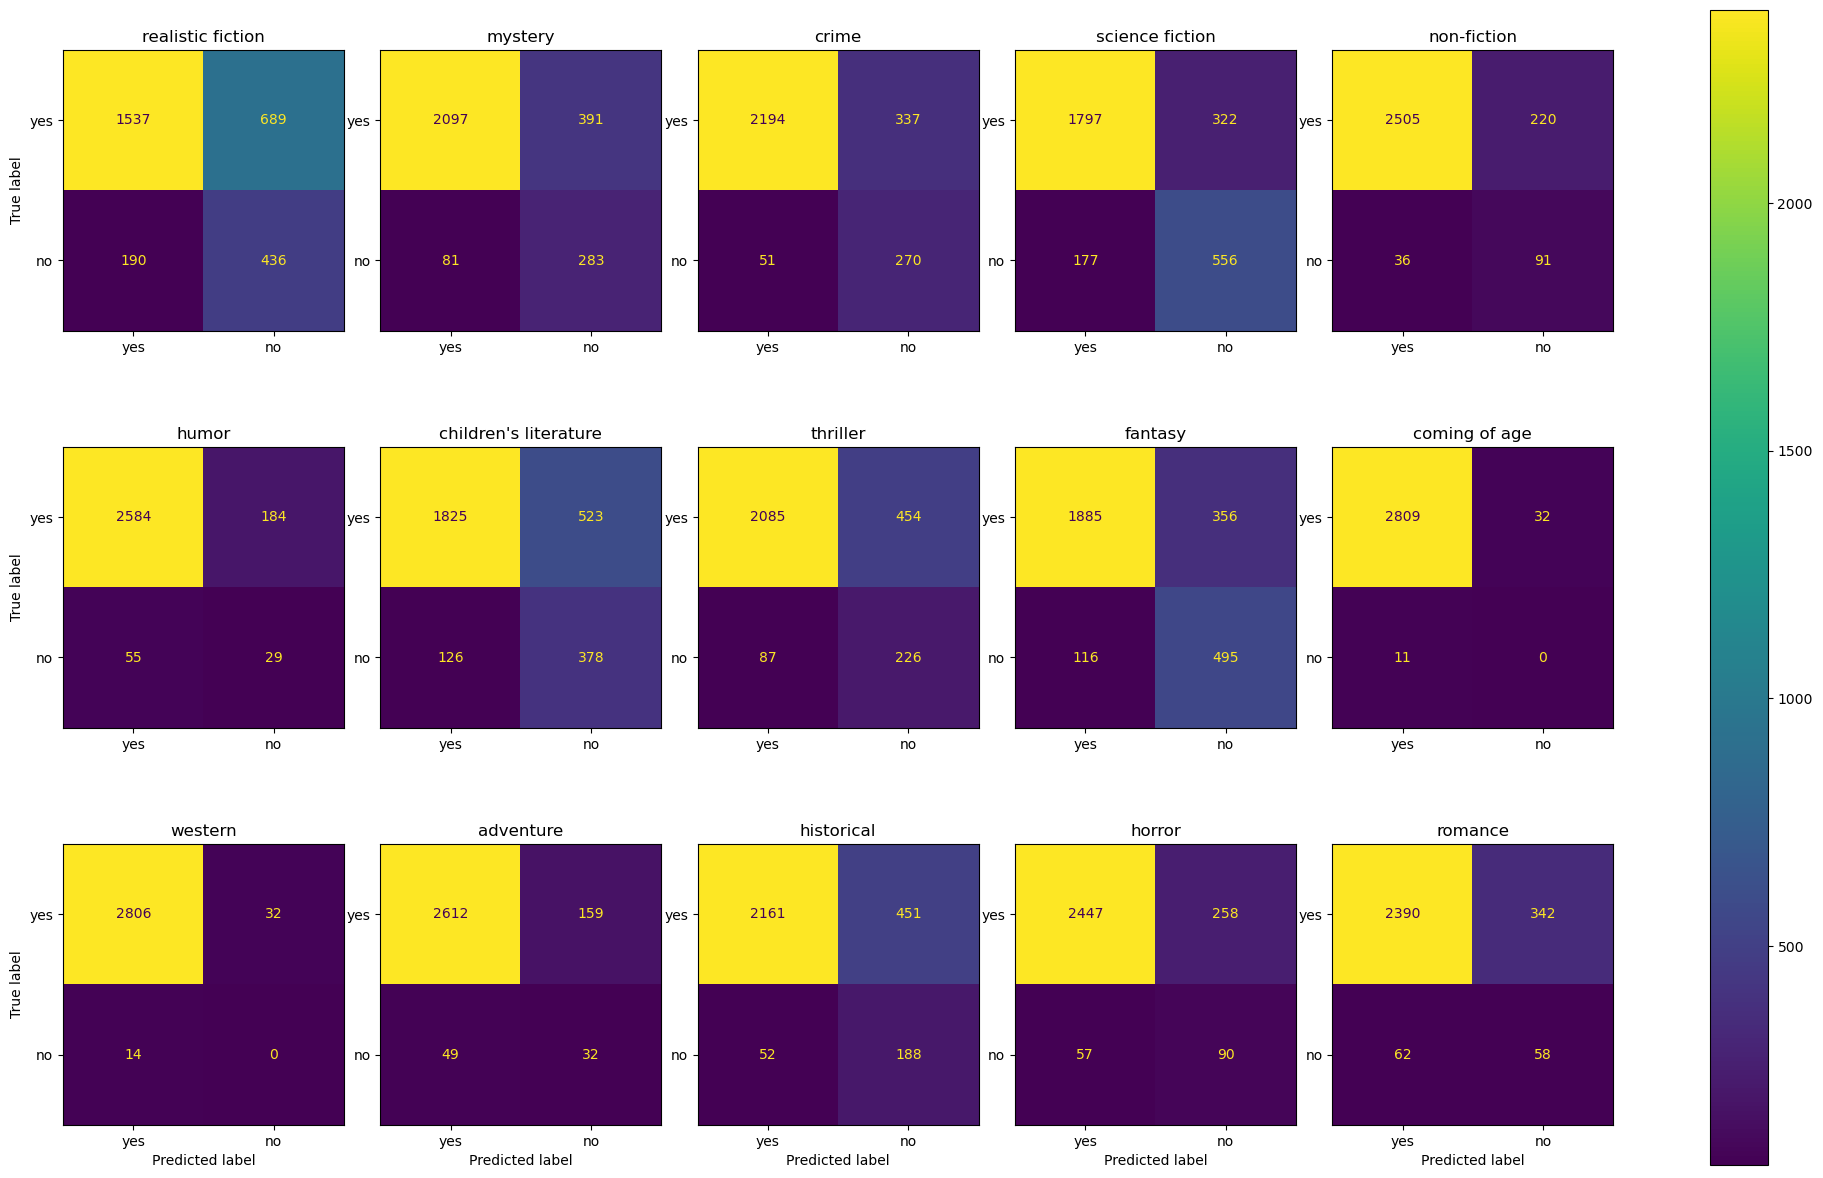

Accuracy : 0.15252454417952313
Hamming loss  0.13824216923796168
Micro
	Precision:	 0.3974
	Recall:		 0.7291
	F1 score:	 0.5144
Macro
	Precision:	 0.3009
	Recall:		 0.5794
	F1 score:	 0.3898
Samples
	Precision:	 0.4706
	Recall:		 0.7644
	F1 score:	 0.5359

Classification Report
                       precision    recall  f1-score   support

    realistic fiction       0.39      0.70      0.50       626
              mystery       0.42      0.78      0.55       364
                crime       0.44      0.84      0.58       321
      science fiction       0.63      0.76      0.69       733
          non-fiction       0.29      0.72      0.42       127
                humor       0.14      0.35      0.20        84
children's literature       0.42      0.75      0.54       504
             thriller       0.33      0.72      0.46       313
              fantasy       0.58      0.81      0.68       611
        coming of age       0.00      0.00      0.00        11
              western      

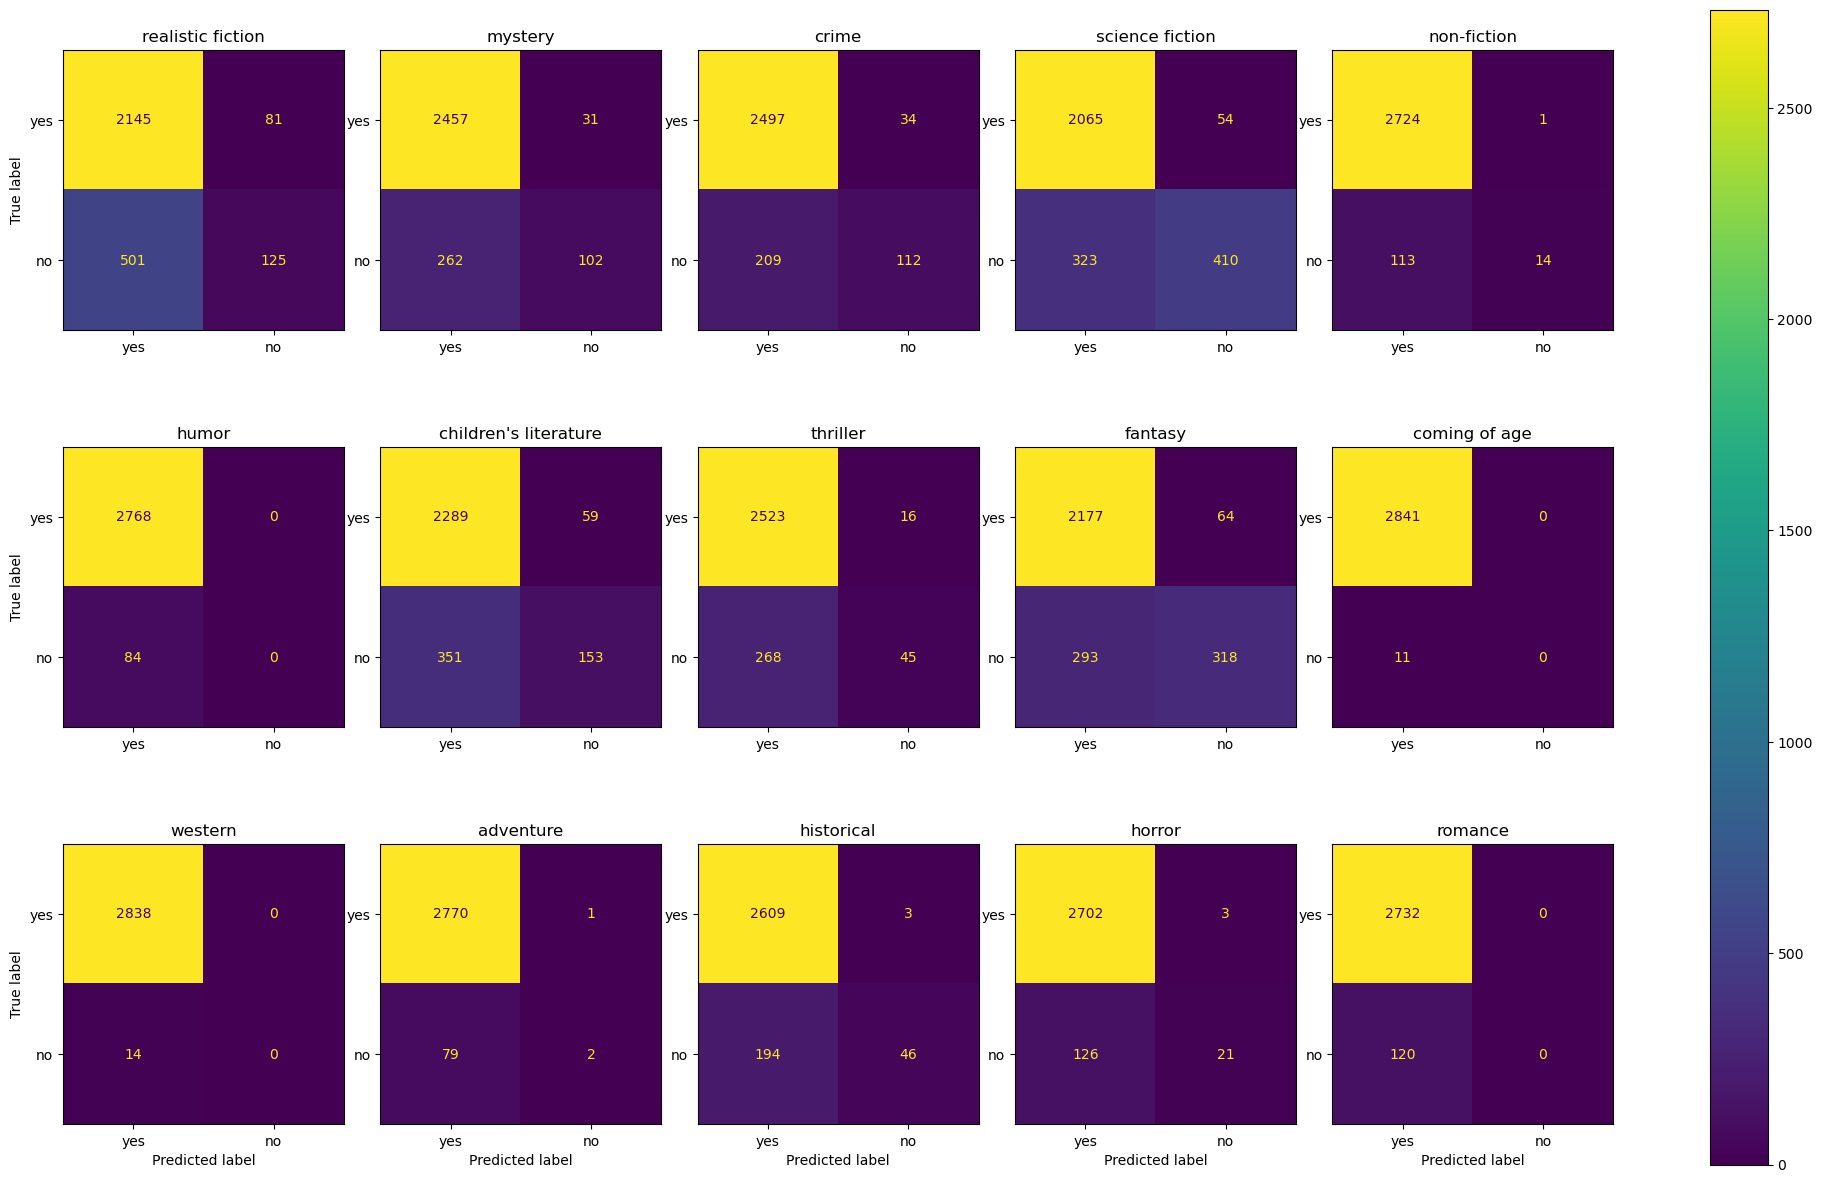

Accuracy : 0.24579242636746143
Hamming loss  0.07702197288452547
Micro
	Precision:	 0.7953
	Recall:		 0.3138
	F1 score:	 0.4500
Macro
	Precision:	 0.5820
	Recall:		 0.1884
	F1 score:	 0.2662
Samples
	Precision:	 0.4022
	Recall:		 0.3436
	F1 score:	 0.3570

Classification Report
                       precision    recall  f1-score   support

    realistic fiction       0.61      0.20      0.30       626
              mystery       0.77      0.28      0.41       364
                crime       0.77      0.35      0.48       321
      science fiction       0.88      0.56      0.69       733
          non-fiction       0.93      0.11      0.20       127
                humor       0.00      0.00      0.00        84
children's literature       0.72      0.30      0.43       504
             thriller       0.74      0.14      0.24       313
              fantasy       0.83      0.52      0.64       611
        coming of age       0.00      0.00      0.00        11
              western      

In [11]:
print('OneVsRest + Transformed Weignt-normalized Complement Naive Bayes')
predictions = clf_twcnb.predict(X_test)
compute_metrics(Y_test, predictions, genres)

print('\nOneVsRest + Logistic regression')
predictions = clf_lr.predict(X_test)
compute_metrics(Y_test, predictions, genres)